## The Impact of *Negative* Correlation

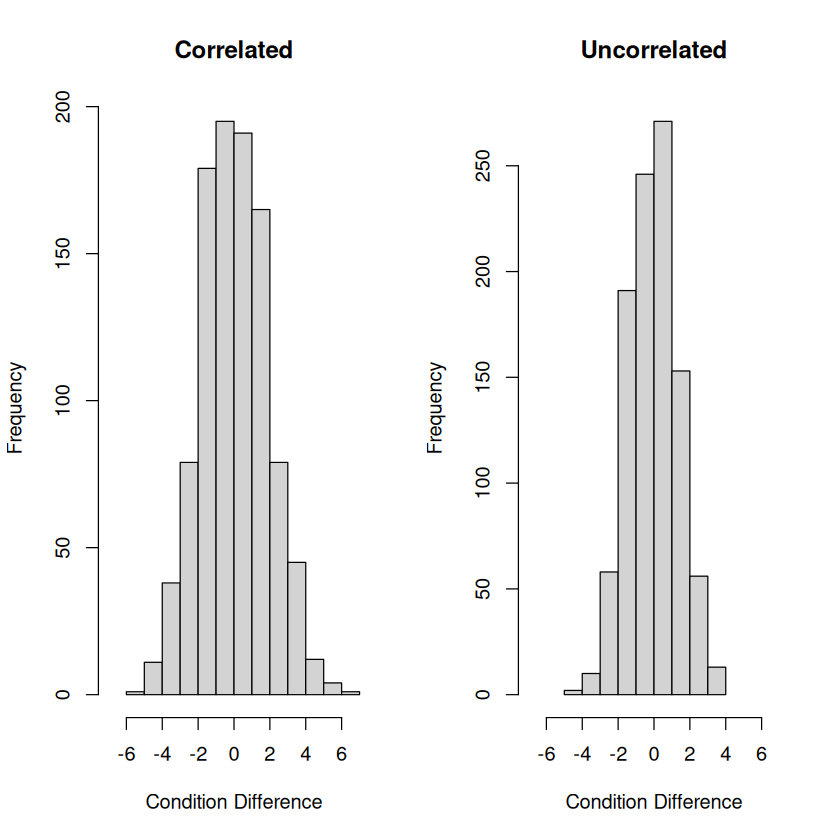

In [1]:
library(MASS)
set.seed(666) # For reproducibility

# Dependent covariance matrix
var1      <- 1             
var2      <- 1             
rho       <- -0.8          
covar     <- rho*sqrt(var1)*sqrt(var2)
Sigma_dep <- matrix(c(var1,covar,covar,var2),2,2)

# Independent covariance matric
rho         <- 0             
covar       <- rho*sqrt(var1)*sqrt(var2)
Sigma_indep <- matrix(c(var1,covar,covar,var2),2,2)

# Sample data
y_dep   <- mvrnorm(n=1000, mu=c(0,0), Sigma=Sigma_dep)
y_indep <- mvrnorm(n=1000, mu=c(0,0), Sigma=Sigma_indep)

# Differences
y_diff_dep   <- y_dep[,1]   - y_dep[,2]
y_diff_indep <- y_indep[,1] - y_indep[,2]

# Plot histograms of differences
par(mfrow=c(1,2))
hist(y_diff_dep,   xlim=c(-7,7), xlab='Condition Difference', main='Correlated')
hist(y_diff_indep, xlim=c(-7,7), xlab='Condition Difference', main='Uncorrelated')

In [ ]:
SE_dep_theory <- sqrt(1 + 1 - 2*(-0.8)) # Theoretical SE
SE_dep_est    <- sd(y_diff_dep)         # Estimated SE from simulation

round(c(SE_dep_theory, SE_dep_est), digits=3)

[1] 1.897 1.867

In [ ]:
SE_indep_theory <- sqrt(1 + 1 - 2*0) # Theoretical SE
SE_indep_est    <- sd(y_diff_indep)  # Estimated SE from simulation

round(c(SE_indep_theory, SE_indep_est), digits=3)

[1] 1.414 1.364

## Try Setting Correlation to 1. What happens?

## Univariate Conceptualisation
IS THIS CONUFSING? 

In [ ]:
library(Matrix)

Sigma.Big <- as.matrix(bdiag(Sigma,Sigma,Sigma))
Mu.Big    <- c(Mu,Mu,Mu)

y <- mvrnorm(n=1, mu=Mu.Big, Sigma=Sigma.Big)

print(y)

[1] 0.6597696 2.2942266 0.5825903 2.7284908 0.4218907 1.6509818


## Multivariate Normal Distribution with > 2 Conditions

### Visualising the Model

We can also visualise what is happening here, to gain further intuition. The plot below shows each mouse along the $x$-axis, with their weight along the $y$-axis. The two treatments are shown for each mouse as two different coloured points and the grand mean is shown as a solid black line

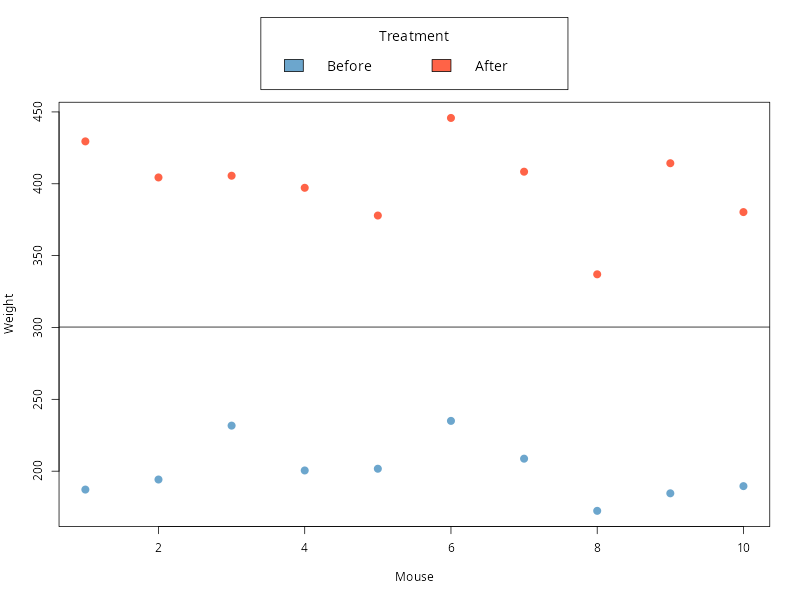

In [ ]:
library(reshape2)
data('mice2')

mice2.long <- melt(mice2, 
                   id.vars       = "id", 
                   variable.name = "treatment", 
                   value.name    = "weight")
p <- par()
par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(mice2.long$id,
     mice2.long$weight,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5)

abline(h=mean(mice2.long$weight), xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

According to the model

$$
y_{ij} = \mu + \alpha_{j} + S_{i} + \eta_{ij}
$$

there are *three* sources of variance that explain why the data deflects from the grand mean. The first is variation associated with the two treatments (the $\alpha_{j}$ terms), the second is variation associated with the different subjects (the $S_{i}$ terms) and the third is random error unrelated to anything else (the $\eta_{ij}$ terms). 

In order to understand this in more detail, and how it relates to repeated measurements, we can *remove* each source of variance from the data and then see what the plot looks like. Starting with the two treatments, if we remove the treatment effects from the data (the $\alpha_{j}$) we get the following 

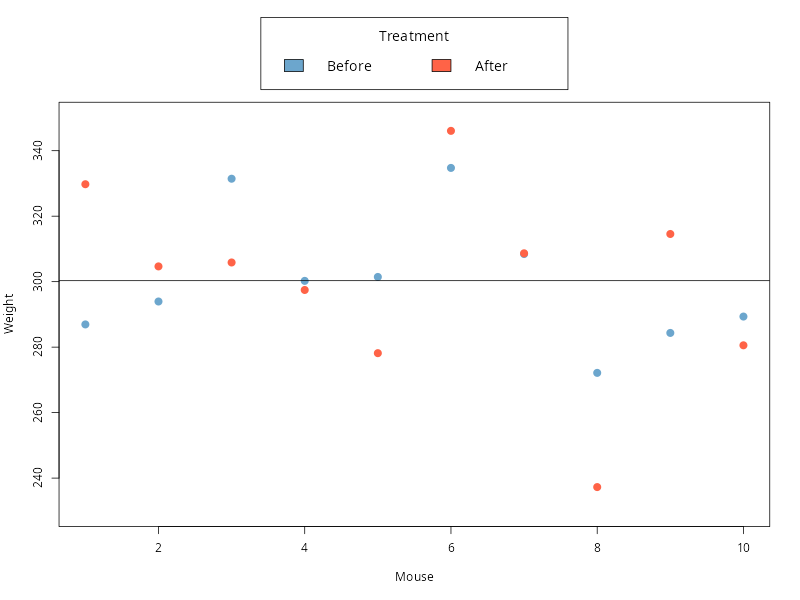

In [ ]:
mod           <- lm(weight ~ treatment, data=mice2.long, contrasts=list(treatment=contr.sum))
res.twosample <- resid(mod)
res.twosample <- res.twosample + coef(mod)[1]

par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(as.numeric(mice2.long$id),
     res.twosample,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5, 
     ylim=c(230,350))

abline(h=coef(mod)[1], xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

Now, after removing the *predictable* element of the variance, we should be left with only the *unpredictable* element. In other words, the plot above shows all the reasons, *other* than the two experimental conditions, why the data do not adhere to the grand mean. This is the *error* in the model. Going back to our model, this shows

$$
y_{ij} - \alpha_{j} = \mu + S_{i} + \eta_{ij}.
$$

So, there are two sources to this error. One relates to the fact that the data come from different subjects and the other is just random noise. Rather than a *single* vertical distance from the grand mean ($\epsilon_{ij}$) we have split this distance into *two* parts: the distance associated with the subject ($S_{i}$) and then anything left over ($\eta_{ij}$). Of interest is that the *correlation* induced by the repeated measurements can be seen above. Notice how the data from each subject is closely linked. For instance, both measurements for mouse 6 are close together and are both *above* the grand mean. Similarly, both measurements for mouse 8 are close together and are both *below* the grand mean. This implies that each mouse has a unique *constant offset* that moves their measurements above or below the grand mean *as a pair*. The fact that this offset moves the measurements *together* explains why the repeated measurements are *correlated*. In principle, if we remove this offset we remove the correlation. 

So, let us see what happens if we remove the constant offset given by $S_{i}$. This gives

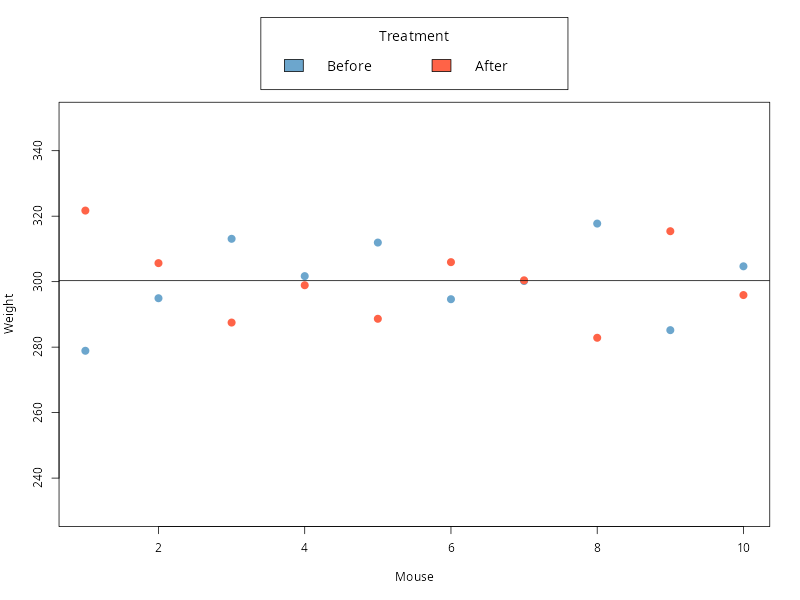

In [ ]:
mice2.long$id <- as.factor(mice2.long$id)
mod           <- lm(weight ~ treatment + id, data=mice2.long, contrasts=list(treatment=contr.sum,id=contr.sum))
res.nosub     <- resid(mod) + coef(mod)[1]

par(mar=c(5.1, 4.1, 7.1, 2.1), xpd=TRUE)

plot(as.numeric(mice2.long$id),
     res.nosub,
     col=c(rep('skyblue3',10),rep('tomato1',10)),
     xlab='Mouse',
     ylab='Weight',
     pch=16,
     cex=1.5, 
     ylim=c(230,350))

abline(h=coef(mod)[1], xpd=FALSE)

legend("top", 
       inset=c(0,-.2), 
       title="Treatment",
       c("Before","After"), 
       fill=c('skyblue3','tomato1'), 
       horiz=TRUE, 
       cex=1.2)

Now we can see that the constant offset that moves each subject in different directions from the grand mean has been removed. Each subject is now *on an equal footing*. Mouse 6 is no longer far above the grand mean, nor is Mouse 8 far below the grand mean. Going back to our model, this shows

$$
y_{ij} - \alpha_{j} - S_{i} = \mu + \eta_{ij}.
$$

We have therefore removed the element that causes the data to be correlated and the only variation left is the random error term $\eta_{ij}$. Subtracting the $S_{i}$ effectively *removes* the value that shifts each subject's measurements *away* from the mean by some amount that is *unique* to each subject, but *constant* across their own measurements. We can think of this like each person having their own "bias" that makes them behave *more* or *less* like the population average. This "bias" is what makes that person's repeats correlated, because this is what makes the measurements similar to each other (i.e. both measurements *larger* than average or *smaller* than average). If we *remove* this "bias", we *remove* the correlation and the only variance that remains is unrelated to each subject. In the paired $t$-test, this is removed *implicitly* by the subtraction of the pairs.